In [32]:
import pandas as pd
import os

BASE_DIR="/home/aiops/zhuty/ret_pretraining_data/id_added/cc/train"
dfs = []
for i in range(0, 100):
    chunk = pd.read_csv(os.path.join(BASE_DIR, "chunk_{}_lengths.csv".format(i)))
    dfs.append(chunk)
df = pd.concat(dfs, ignore_index=True)

print(df['length'].describe())
print("Total number of tokens (B): ", df['length'].sum()/1e9)

# df = pd.read_csv("chunk_99_lengths.csv")
# get how many lengths are smaller than 1k, 2k, 4k, 8k
for threshold in [1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000]:
    print("Number of documents with length smaller than {}: ".format(threshold), df[df['length'] < threshold].shape[0], "({:.2f}%)".format(df[df['length'] < threshold].shape[0]/df.shape[0]*100))
    print("Number of tokens (B) with length smaller than {}: ".format(threshold), df[df['length'] < threshold]['length'].sum()/1e9, "({:.2f}%)".format(df[df['length'] < threshold]['length'].sum()/df['length'].sum()*100))
# get the distribution of the lengths
print(df['length'].describe())
print("Total number of tokens (B): ", df['length'].sum()/1e9)


count    1.575382e+07
mean     1.972632e+03
std      4.566829e+03
min      4.500000e+01
25%      6.510000e+02
50%      1.067000e+03
75%      1.867000e+03
max      5.942720e+05
Name: length, dtype: float64
Total number of tokens (B):  31.076485813
Number of documents with length smaller than 1000:  7342657 (46.61%)
Number of tokens (B) with length smaller than 1000:  4.558852222 (14.67%)
Number of documents with length smaller than 2000:  12168793 (77.24%)
Number of tokens (B) with length smaller than 2000:  11.318629585 (36.42%)
Number of documents with length smaller than 4000:  14390219 (91.34%)
Number of tokens (B) with length smaller than 4000:  17.376431543 (55.92%)
Number of documents with length smaller than 8000:  15227710 (96.66%)
Number of tokens (B) with length smaller than 8000:  21.972798634 (70.71%)
Number of documents with length smaller than 16000:  15591275 (98.97%)
Number of tokens (B) with length smaller than 16000:  25.954696569 (83.52%)
Number of documents with len

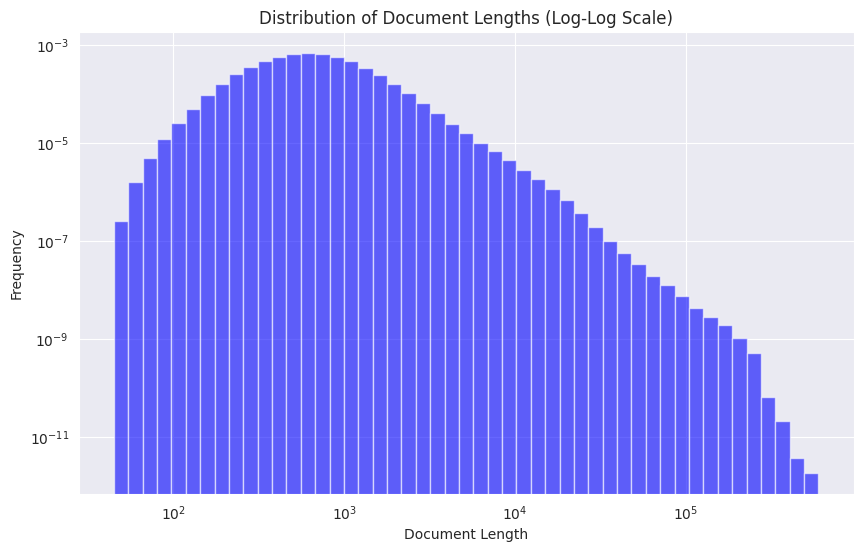

In [33]:

#
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'lengths' is your numpy array of document lengths
# lengths = np.array([...])
lengths = df['length'].values

# Create logarithmically spaced bins
min_length = lengths.min()
max_length = lengths.max()
bins = np.logspace(np.log10(min_length), np.log10(max_length), 50)

# Plot the histogram of the lengths with logarithmically spaced bins
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=bins, density=True, alpha=0.6, color='b')

# Set log scale for x and y axis
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths (Log-Log Scale)')
plt.grid(True)

plt.show()


In [34]:

import numpy as np
import matplotlib.pyplot as plt

# Sample lengths array
# lengths = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
lengths = df['length'].values.tolist()
lengths = lengths[:int(len(lengths)/10)]
print(lengths[:10])

# Add EOS tokens between documents
eos_token_length = 1
# insert 1 into lengths every time we see a new document
lengths_with_eos = np.insert(lengths, np.arange(1, len(lengths)), eos_token_length)
lengths_with_eos = lengths_with_eos.tolist()
print(lengths_with_eos[:10])

# Constants
context_length = 8192
estimated_number_of_chunks = sum(lengths_with_eos) // context_length

concatenated_chunks = []

def calculate_eos_tokens(lengths, context_length):
    current_length = 0
    curr_chunk = []
    eos_counts = []
    while lengths:
        doc_length = lengths.pop(0)
        if current_length + doc_length == context_length:
            curr_chunk.append(doc_length)
            concatenated_chunks.append(curr_chunk)
            eos_counts.append(curr_chunk.count(eos_token_length))
            current_length = 0
            curr_chunk = []
            if len(concatenated_chunks) % 1000 == 0:
                print("in total you created {} chunks".format(len(concatenated_chunks)),
                      "which is {:.2f}% of the estimated number of chunks".format(len(concatenated_chunks) / estimated_number_of_chunks * 100))
        elif current_length + doc_length > context_length:
            remaining_length = doc_length - (context_length - current_length)
            curr_chunk.append(context_length - current_length)
            lengths.insert(0, remaining_length)
            concatenated_chunks.append(curr_chunk)
            eos_counts.append(curr_chunk.count(eos_token_length))
            current_length = 0
            curr_chunk = []
            if len(concatenated_chunks) % 1000 == 0:
                print("in total you created {} chunks".format(len(concatenated_chunks)),
                      "which is {:.2f}% of the estimated number of chunks".format(len(concatenated_chunks) / estimated_number_of_chunks * 100))
        else:
            current_length += doc_length
            curr_chunk.append(doc_length)
    print("in total you created {} chunks".format(len(concatenated_chunks)))
    return eos_counts

eos_counts = calculate_eos_tokens(lengths_with_eos, context_length)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(eos_counts, bins=range(min(eos_counts), max(eos_counts) + 2), edgecolor='black', density=True)
plt.title('Distribution of EOS Tokens')
plt.xlabel('Number of EOS Tokens')
plt.ylabel('Frequency')
plt.show()


[567, 873, 1361, 480, 534, 1538, 1182, 861, 1063, 582]
[567, 1, 873, 1, 1361, 1, 480, 1, 534, 1]
in total you created 1000 chunks which is 0.26% of the estimated number of chunks
in total you created 2000 chunks which is 0.53% of the estimated number of chunks
in total you created 3000 chunks which is 0.79% of the estimated number of chunks
in total you created 4000 chunks which is 1.06% of the estimated number of chunks
in total you created 5000 chunks which is 1.32% of the estimated number of chunks
in total you created 6000 chunks which is 1.58% of the estimated number of chunks
in total you created 7000 chunks which is 1.85% of the estimated number of chunks
in total you created 8000 chunks which is 2.11% of the estimated number of chunks
in total you created 9000 chunks which is 2.37% of the estimated number of chunks
in total you created 10000 chunks which is 2.64% of the estimated number of chunks
in total you created 11000 chunks which is 2.90% of the estimated number of chunks

KeyboardInterrupt: 

In [86]:
# save the eos_counts
import numpy as np
# np.save("/home/aiops/zhuty/eos_counts_cc8k.npy", eos_counts)

In [ ]:
list(df['length'])[-1]

### Directly analyze the EOS numbers


EOS counts for cc:
Mean:  4.16769
Median:  4.0
Max:  13
Min:  0
Std:  2.7451065669478116
EOS counts for cc_v42:
Mean:  8.84751
Median:  9.0
Max:  20
Min:  4
Std:  1.9417252122532687
EOS counts for cc_v4:
Mean:  8.81593
Median:  9.0
Max:  16
Min:  5
Std:  1.505950940469177


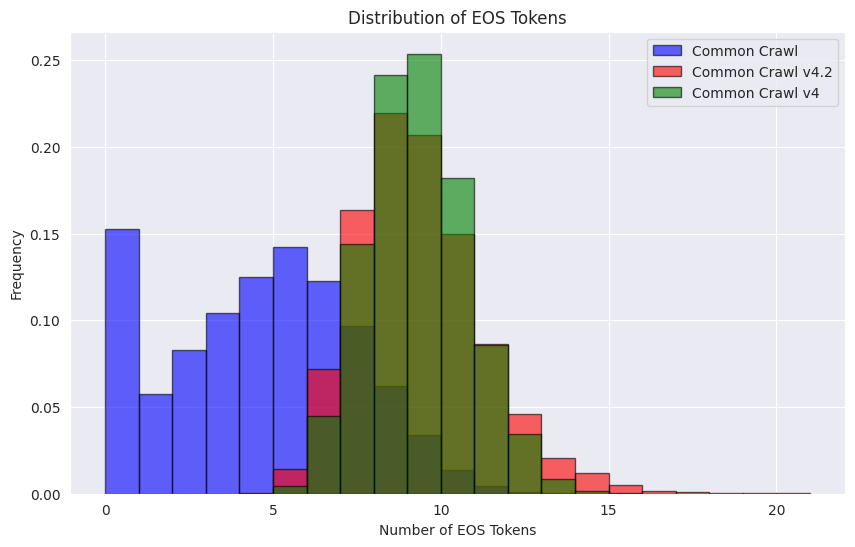

In [36]:
import numpy as np
eos_data = {}
for version in ['cc', 'cc_v42', 'cc_v4']:
    path = f"/home/aiops/zhuty/tinyllama/processing/corpus_analysis/{version}_8k_eos_counts.npy"
    eos_counts = np.load(path)
    eos_data[version] = eos_counts
    print(f"EOS counts for {version}:")
    print("Mean: ", np.mean(eos_counts))
    print("Median: ", np.median(eos_counts))
    print("Max: ", np.max(eos_counts))
    print("Min: ", np.min(eos_counts))
    print("Std: ", np.std(eos_counts))

# plot the distribution of EOS tokens
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(eos_data['cc'], bins=range(min(eos_data['cc']), max(eos_data['cc']) + 2), edgecolor='black', density=True, alpha=0.6, color='b', label='Common Crawl')
plt.hist(eos_data['cc_v42'], bins=range(min(eos_data['cc_v42']), max(eos_data['cc_v42']) + 2), edgecolor='black', density=True, alpha=0.6, color='r', label='Common Crawl v4.2')
plt.hist(eos_data['cc_v4'], bins=range(min(eos_data['cc_v4']), max(eos_data['cc_v4']) + 2), edgecolor='black', density=True, alpha=0.6, color='g', label='Common Crawl v4')
plt.title('Distribution of EOS Tokens')
plt.xlabel('Number of EOS Tokens')
plt.ylabel('Frequency')
plt.legend()


In [41]:
# get the frequency distribution
from collections import Counter
cc_eos_counts = Counter(eos_data['cc'])
cc_v42_eos_counts = Counter(eos_data['cc_v42'])
cc_v4_eos_counts = Counter(eos_data['cc_v4'])
cc_eos_counts = dict(cc_eos_counts)
# divide by the total number of instances
total_instances = len(eos_data['cc'])
cc_eos_counts = {k: v/total_instances for k, v in cc_eos_counts.items()}

In [67]:
print(len(eos_data['cc']))
print(len(eos_data['cc_v42']))

100000
100000


In [71]:
source_to_target_dict = {}
for target, source  in zip(sorted(eos_data['cc']), sorted(eos_data['cc_v42'])):
    assert target < source
    if source in source_to_target_dict:
        source_to_target_dict[source].append(target)
    else:
        source_to_target_dict[source] = [target]

# normalize the distribution
for source, targets in source_to_target_dict.items():
    total = len(targets)
    source_to_target_dict[source] = {k: v/total for k, v in Counter(targets).items()}
print(source_to_target_dict)

{4: {0: 1.0}, 5: {0: 1.0}, 6: {0: 1.0}, 7: {0: 0.4057439657806294, 1: 0.3525206232813932, 2: 0.2417354109379774}, 8: {2: 0.19703804966962862, 3: 0.47527910685805425, 4: 0.32768284347231713}, 9: {4: 0.2564597923206955, 5: 0.6882878531755614, 6: 0.05525235450374306}, 10: {6: 0.7427482956823954, 7: 0.2572517043176046}, 11: {7: 0.6765799256505576, 8: 0.32342007434944237}, 12: {8: 0.7440944881889764, 9: 0.2559055118110236}, 13: {9: 1.0}, 14: {9: 0.11928934010152284, 10: 0.8807106598984772}, 15: {10: 0.6507633587786259, 11: 0.34923664122137404}, 16: {11: 1.0}, 17: {11: 1.0}, 18: {11: 0.4, 12: 0.6}, 19: {12: 1.0}, 20: {12: 0.4098360655737705, 13: 0.5901639344262295}}


In [72]:
def get_new_count(input_count, target_count_distribution):
    # first, filter out the counts larger than the input count
    # target_count_distribution = {k: v for k, v in target_count_distribution.items() if k <= input_count}
    # if len(target_count_distribution) == 0:
      #  return input_count
    # renormalize the distribution
    #total = sum(target_count_distribution.values())
    #target_count_distribution = {k: v/total for k, v in target_count_distribution.items()}

    # randomly sample from the target count distribution
    target_counts = list(target_count_distribution.keys())
    target_probs = list(target_count_distribution.values())
    new_count = np.random.choice(target_counts, p=target_probs)
    if new_count > input_count:
        return input_count
    else:
        return new_count

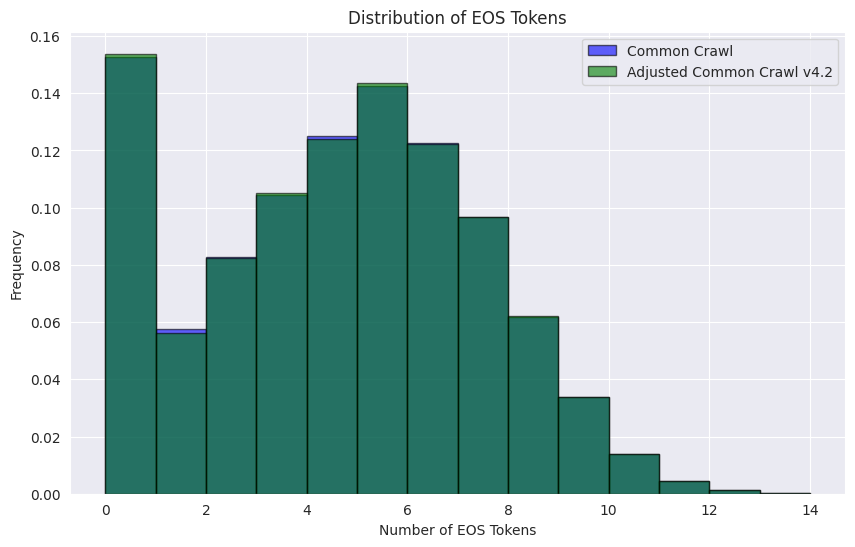

In [73]:

source_counts = eos_data['cc_v42']
new_counts = []
for eos_count in source_counts:
    # new_count = get_new_count(eos_count, target_count_distribution=cc_eos_counts)
    target_count_distribution = source_to_target_dict[eos_count]
    new_count = get_new_count(eos_count, target_count_distribution)
    new_counts.append(new_count)
    assert new_count <= eos_count
    # print(f"EOS count: {eos_count}, new count: {new_count}")

new_counts = np.array(new_counts)
# plot the distribution of EOS tokens
plt.figure(figsize=(10, 6))
plt.hist(eos_data['cc'], bins=range(min(eos_data['cc']), max(eos_data['cc']) + 2), edgecolor='black', density=True, alpha=0.6, color='b', label='Common Crawl')
# plt.hist(source_counts, bins=range(min(source_counts), max(source_counts) + 2), edgecolor='black', density=True, alpha=0.6, color='r', label='Common Crawl v4.2')
plt.hist(new_counts, bins=range(min(new_counts), max(new_counts) + 2), edgecolor='black', density=True, alpha=0.6, color='g', label='Adjusted Common Crawl v4.2')
plt.title('Distribution of EOS Tokens')
plt.xlabel('Number of EOS Tokens')
plt.ylabel('Frequency')
plt.legend()


In [42]:
#cc_eos_counts

{5: 0.14251,
 4: 0.12501,
 6: 0.12257,
 2: 0.0828,
 3: 0.1043,
 0: 0.1528,
 1: 0.05769,
 7: 0.09673,
 8: 0.06186,
 9: 0.03382,
 10: 0.01382,
 11: 0.00452,
 12: 0.00121,
 13: 0.00036}

In [39]:
eos_data['cc'][0]

5

In [37]:
# how to make the two distributions similar?
import numpy as np
from scipy.stats import percentileofscore, scoreatpercentile

lower_counts = eos_data['cc']
higher_counts = eos_data['cc_v42']

lower_cdf = np.array([percentileofscore(lower_counts, x) for x in lower_counts]) / 100
higher_cdf = np.array([percentileofscore(higher_counts, x) for x in higher_counts]) / 100

# Match to the target distribution
target_counts = np.array([scoreatpercentile(lower_counts, p*100) for p in higher_cdf])

# Output the adjusted counts
adjusted_counts = np.minimum(higher_counts, target_counts)
print(adjusted_counts)

KeyboardInterrupt: 

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'lengths' is your numpy array of document lengths
# lengths = np.array([...])

# Define the bins: 0-1k, 1-2k, ..., 15-16k, >16k
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, np.inf]

# Step 1: Separate the documents
real_docs = lengths[lengths < 8000]
fake_docs = lengths[lengths >= 8000]

# Step 2: Shuffle the real documents
np.random.shuffle(real_docs)

# Step 3: Track total tokens and create target lengths for fake documents
total_tokens = np.sum(real_docs)
target_lengths = []

for length in fake_docs:
    if total_tokens >= length:
        target_lengths.append(length)
        total_tokens -= length

# Step 4: Concatenate shorter documents to create fake documents
concatenated_docs = []
current_doc = []

for target_length in target_lengths:
    current_length = 0
    while current_length < target_length:
        if len(real_docs) == 0:
            break
        doc = real_docs[0]
        real_docs = real_docs[1:]
        current_doc.append(doc)
        current_length += doc

    if current_length >= target_length:
        concatenated_docs.append(current_length)
        current_doc = []

# Step 5: Combine the real documents and concatenated fake documents
final_lengths = np.concatenate((real_docs, np.array(concatenated_docs)))


# Step 5: Calculate the number of tokens in each bin for both distributions
original_tokens_per_bin, _ = np.histogram(lengths, bins=bins, weights=lengths, density=True)
new_tokens_per_bin, _ = np.histogram(final_lengths, bins=bins, weights=final_lengths, density=True)

# Plot the number of tokens per bin for both distributions
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-2)] + [">16000"]

x = np.arange(len(bin_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, original_tokens_per_bin, width, label='Original Tokens')
rects2 = ax.bar(x + width/2, new_tokens_per_bin, width, label='New Tokens')

ax.set_xlabel('Document Length Bins')
ax.set_ylabel('Number of Tokens')
ax.set_title('Number of Tokens in Each Bin for Original and New Distributions')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


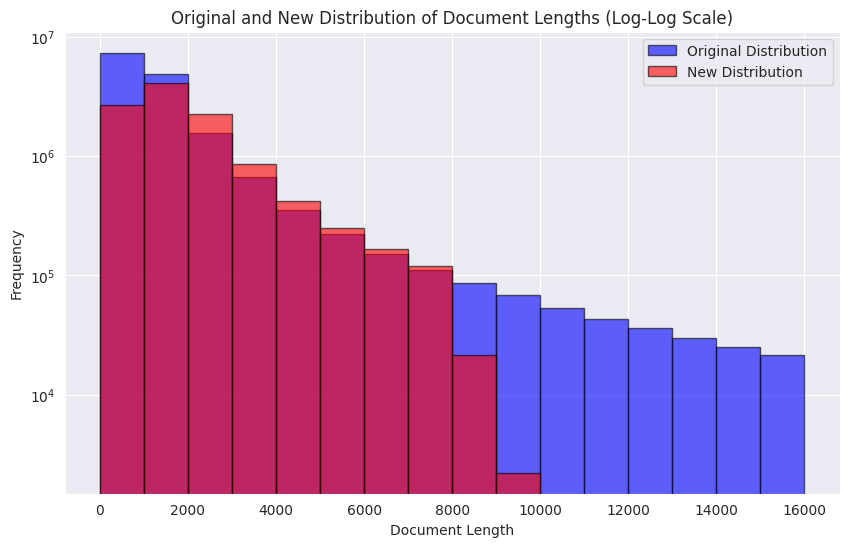

In [37]:

# Step 5: Plot the original and new distributions using defined bins
plt.figure(figsize=(10, 6))

# Plot original distribution
plt.hist(lengths, bins=bins, alpha=0.6, color='b', label='Original Distribution', edgecolor='black')

# Plot new distribution
plt.hist(final_lengths, bins=bins, alpha=0.6, color='r', label='New Distribution', edgecolor='black')

#plt.xscale('log')
plt.yscale('log')

plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Original and New Distribution of Document Lengths (Log-Log Scale)')
plt.legend()
plt.grid(True)

plt.show()

In [23]:
print("original total number of tokens (B): ", lengths.sum()/1e9)
print("new total number of tokens (B): ", final_lengths.sum()/1e9)

original total number of tokens (B):  31.076485813
new total number of tokens (B):  21.972798634


In [4]:
all_commands = []
for context_length in [2**x for x in range(6, 30)]:
    commands = 'source /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/processing/corpus_analysis ; '
    for max_doc_length in [2**x for x in range(6, 30)]:
         commands += f'bash eos_simulation.sh {context_length} {max_doc_length} ;'
    base_command = f"sailctl job create sim{context_length} -g 1 --debug -p high --command-line-args '{commands}'"
    all_commands.append(base_command)


In [5]:
print(all_commands)

["sailctl job create sim64 -g 1 --debug -p high --command-line-args 'source /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/processing/corpus_analysis ; bash eos_simulation.sh 64 64 ;bash eos_simulation.sh 64 128 ;bash eos_simulation.sh 64 256 ;bash eos_simulation.sh 64 512 ;bash eos_simulation.sh 64 1024 ;bash eos_simulation.sh 64 2048 ;bash eos_simulation.sh 64 4096 ;bash eos_simulation.sh 64 8192 ;bash eos_simulation.sh 64 16384 ;bash eos_simulation.sh 64 32768 ;bash eos_simulation.sh 64 65536 ;bash eos_simulation.sh 64 131072 ;bash eos_simulation.sh 64 262144 ;bash eos_simulation.sh 64 524288 ;bash eos_simulation.sh 64 1048576 ;bash eos_simulation.sh 64 2097152 ;bash eos_simulation.sh 64 4194304 ;bash eos_simulation.sh 64 8388608 ;bash eos_simulation.sh 64 16777216 ;bash eos_simulation.sh 64 33554432 ;bash eos_simulation.sh 64 67108864 ;bash eos_simulation.sh 64 134217728 ;bash eos_simulation.sh 64 268435456 ;bash eos_simulation.sh 64 536870912 ;'", "sailctl job create 

In [7]:
print(all_commands[0])

sailctl job create sim64 -g 1 --debug -p high --command-line-args 'source /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/processing/corpus_analysis ; bash eos_simulation.sh 64 64 ;bash eos_simulation.sh 64 128 ;bash eos_simulation.sh 64 256 ;bash eos_simulation.sh 64 512 ;bash eos_simulation.sh 64 1024 ;bash eos_simulation.sh 64 2048 ;bash eos_simulation.sh 64 4096 ;bash eos_simulation.sh 64 8192 ;bash eos_simulation.sh 64 16384 ;bash eos_simulation.sh 64 32768 ;bash eos_simulation.sh 64 65536 ;bash eos_simulation.sh 64 131072 ;bash eos_simulation.sh 64 262144 ;bash eos_simulation.sh 64 524288 ;bash eos_simulation.sh 64 1048576 ;bash eos_simulation.sh 64 2097152 ;bash eos_simulation.sh 64 4194304 ;bash eos_simulation.sh 64 8388608 ;bash eos_simulation.sh 64 16777216 ;bash eos_simulation.sh 64 33554432 ;bash eos_simulation.sh 64 67108864 ;bash eos_simulation.sh 64 134217728 ;bash eos_simulation.sh 64 268435456 ;bash eos_simulation.sh 64 536870912 ;'


In [8]:
print(";sleep 1;".join(all_commands))

sailctl job create sim64 -g 1 --debug -p high --command-line-args 'source /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/processing/corpus_analysis ; bash eos_simulation.sh 64 64 ;bash eos_simulation.sh 64 128 ;bash eos_simulation.sh 64 256 ;bash eos_simulation.sh 64 512 ;bash eos_simulation.sh 64 1024 ;bash eos_simulation.sh 64 2048 ;bash eos_simulation.sh 64 4096 ;bash eos_simulation.sh 64 8192 ;bash eos_simulation.sh 64 16384 ;bash eos_simulation.sh 64 32768 ;bash eos_simulation.sh 64 65536 ;bash eos_simulation.sh 64 131072 ;bash eos_simulation.sh 64 262144 ;bash eos_simulation.sh 64 524288 ;bash eos_simulation.sh 64 1048576 ;bash eos_simulation.sh 64 2097152 ;bash eos_simulation.sh 64 4194304 ;bash eos_simulation.sh 64 8388608 ;bash eos_simulation.sh 64 16777216 ;bash eos_simulation.sh 64 33554432 ;bash eos_simulation.sh 64 67108864 ;bash eos_simulation.sh 64 134217728 ;bash eos_simulation.sh 64 268435456 ;bash eos_simulation.sh 64 536870912 ;';sleep 1;sailctl job crea